In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-eyh8s89u because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils import resample
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

## Run the Deicision Tree Model (with feature selection)

In [3]:
# Let's load the dataset
df = pd.read_csv("processed_data_newyork_15042025.csv")

# Drop stations with ≤ 2 years of data
station_years = df.groupby('name')['year'].nunique()
valid_stations = station_years[station_years > 2].index
df = df[df['name'].isin(valid_stations)]

In [4]:
# Let's do the log transformation of the counts variable
df['log_counts'] = np.log1p(df['counts'])

In [5]:
# Station-wise temporal train-test split
train_list, test_list = [], []

for station in df['name'].unique():
    station_data = df[df['name'] == station].sort_values('date')
    last_year = station_data['year'].max()

    train = station_data[station_data['year'] < last_year]
    test = station_data[station_data['year'] == last_year]

    if not train.empty and not test.empty:
        train_list.append(train)
        test_list.append(test)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

In [6]:
# Define features and target
non_features = ['name', 'date', 'year', 'counts', 'log_counts']
features = [col for col in df.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['log_counts']

X_test = test_df[features]
y_test_log = test_df['log_counts']
y_test_true = test_df['counts'] 

In [7]:
# Feature selection with Sequential Forward Selection
base_tree = DecisionTreeRegressor(random_state=42)
sfs = SequentialFeatureSelector(
    base_tree,
    n_features_to_select='auto',
    direction='forward',
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5),
    n_jobs=-1
)
sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print("\nSelected features by SFS for Decision Tree:")
print(selected_features.tolist())


Selected features by SFS for Decision Tree:
['latitude', 'shops_within_0km', 'education_within_0km', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'wdir', 'public_holiday', 'avg_motor_volume', 'total_motor_volume', 'city_avg_motor_volume', 'day_of_week', 'is_weekend', 'bicycle_lane_type_lane', 'bicycle_lane_type_none', 'bicycle_lane_type_track', 'Other Impervious', 'Railroads', 'Bare Soil', 'Water']


In [8]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['squared_error', 'friedman_mse']
}

tree = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(
    tree,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5),
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train[selected_features], y_train)

print("\nBest hyperparameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best hyperparameters:
{'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [9]:
# Final Model: Train with best params
final_tree = grid_search.best_estimator_
y_pred_log = final_tree.predict(X_test[selected_features])
y_pred = np.expm1(y_pred_log)

# Let's define the SMAPE
def smape(y_true, y_pred):
    epsilon = 1e-8  # to avoid division by zero
    denominator = np.abs(y_true) + np.abs(y_pred) + epsilon
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / denominator)

In [10]:
# Drop NaNs (if any)
valid_idx = ~np.isnan(y_pred)
y_true_daily = y_test_true[valid_idx]
y_pred_daily = y_pred[valid_idx]

# Set-up the daily level evaluation
mae_daily = mean_absolute_error(y_true_daily, y_pred_daily)
rmse_daily = np.sqrt(mean_squared_error(y_true_daily, y_pred_daily))
smape_daily = smape(y_true_daily, y_pred_daily)

print(f"\nDaily Level Evaluation:")
print(f"MAE  : {mae_daily:.2f}")
print(f"RMSE : {rmse_daily:.2f}")
print(f"SMAPE: {smape_daily:.2f}%")


Daily Level Evaluation:
MAE  : 588.77
RMSE : 872.17
SMAPE: 47.01%


In [11]:
# AADB evaluation
test_df['predicted_volume'] = y_pred
aadb_actual = test_df.groupby(['name', 'year'])['counts'].mean()
aadb_pred = test_df.groupby(['name', 'year'])['predicted_volume'].mean()

aadb_eval = pd.concat([aadb_actual, aadb_pred], axis=1)
aadb_eval.columns = ['actual', 'predicted']

mae_aadb = mean_absolute_error(aadb_eval['actual'], aadb_eval['predicted'])
rmse_aadb = np.sqrt(mean_squared_error(aadb_eval['actual'], aadb_eval['predicted']))

smape_aadb = smape(aadb_eval['actual'], aadb_eval['predicted'])

print(f"\nAADB Level Evaluation:")
print(f"MAE  : {mae_aadb:.2f}")
print(f"RMSE : {rmse_aadb:.2f}")
print(f"SMAPE: {smape_aadb:.2f}%")


AADB Level Evaluation:
MAE  : 451.84
RMSE : 543.63
SMAPE: 32.72%


## True vs Predicted Values (Daily and AADB level)

In [12]:
# Set global font weight to bold
plt.rcParams.update({'font.weight': 'bold',
                     'axes.labelweight': 'bold',
                     'axes.titleweight': 'bold',
                     'xtick.labelsize': 'large',
                     'ytick.labelsize': 'large',
                     'axes.labelsize': 'large',
                     'axes.titlesize': 'x-large'})

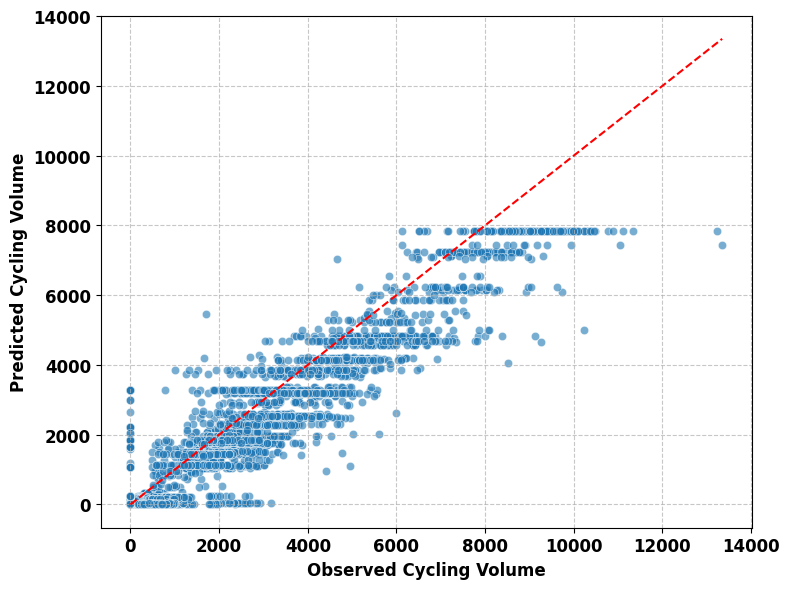

In [13]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true_daily, y=y_pred_daily, alpha=0.6)
plt.plot([0, max(y_true_daily.max(), y_pred_daily.max())], 
         [0, max(y_true_daily.max(), y_pred_daily.max())], 
         color='red', linestyle='--')  # 45 degree line
plt.xlabel('Observed Cycling Volume')
plt.ylabel('Predicted Cycling Volume')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

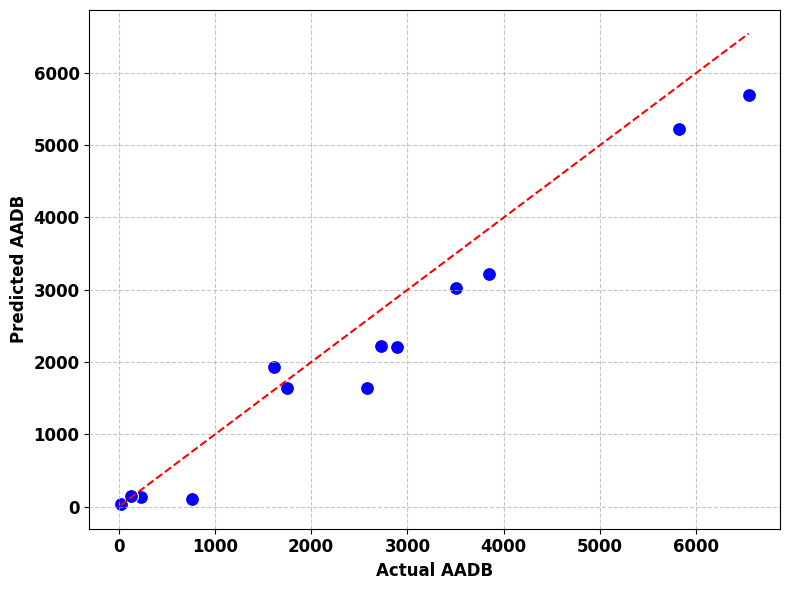

In [14]:
# Aggregate to station-year level
aadb_eval_reset = aadb_eval.reset_index()

# Scatter Plot: AADB Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=aadb_eval_reset['actual'],
    y=aadb_eval_reset['predicted'],
    s=100,
    color='blue'
)
plt.plot([aadb_eval_reset['actual'].min(), aadb_eval_reset['actual'].max()],
         [aadb_eval_reset['actual'].min(), aadb_eval_reset['actual'].max()],
         color='red', linestyle='--')
plt.xlabel('Actual AADB')
plt.ylabel('Predicted AADB')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Station-level Error Analysis (Daily and AADB Level)

In [15]:
# Merge test set true and predicted values
test_df['true_volume'] = y_test_true.values
test_df['predicted_volume'] = y_pred

# Group by station
station_error = test_df.groupby('name').apply(
    lambda group: pd.Series({
        'MAE': mean_absolute_error(group['true_volume'], group['predicted_volume']),
        'RMSE': np.sqrt(mean_squared_error(group['true_volume'], group['predicted_volume'])),
        'SMAPE': smape(group['true_volume'].values, group['predicted_volume'].values)
    })
).reset_index()

print("\nStation-Level Errors (New York):")
print(station_error)


Station-Level Errors (New York):
                                          name          MAE         RMSE  \
0                         111th St at 50th Ave    98.061396   122.371200   
1                          8th Ave at 50th St.   615.370175   734.283618   
2                    Amsterdam Ave at 86th St.   942.834283  1035.794771   
3       Brooklyn Bridge Bicycle Path (Roadway)   812.478933  1065.677943   
4                    Brooklyn Bridge Bike Path    13.458413    16.353998   
5                     Columbus Ave at 86th St.   197.953032   259.348247   
6        Ed Koch Queensboro Bridge Shared Path   793.050972   968.374176   
7   Kent Ave btw North 8th St and North 9th St   638.978965   831.652570   
8                    Manhattan Bridge Ped Path    25.637362    32.687084   
9                           Prospect Park West   913.791193  1339.368150   
10                              Pulaski Bridge   766.233348   903.816236   
11                         Staten Island Ferry   649.7

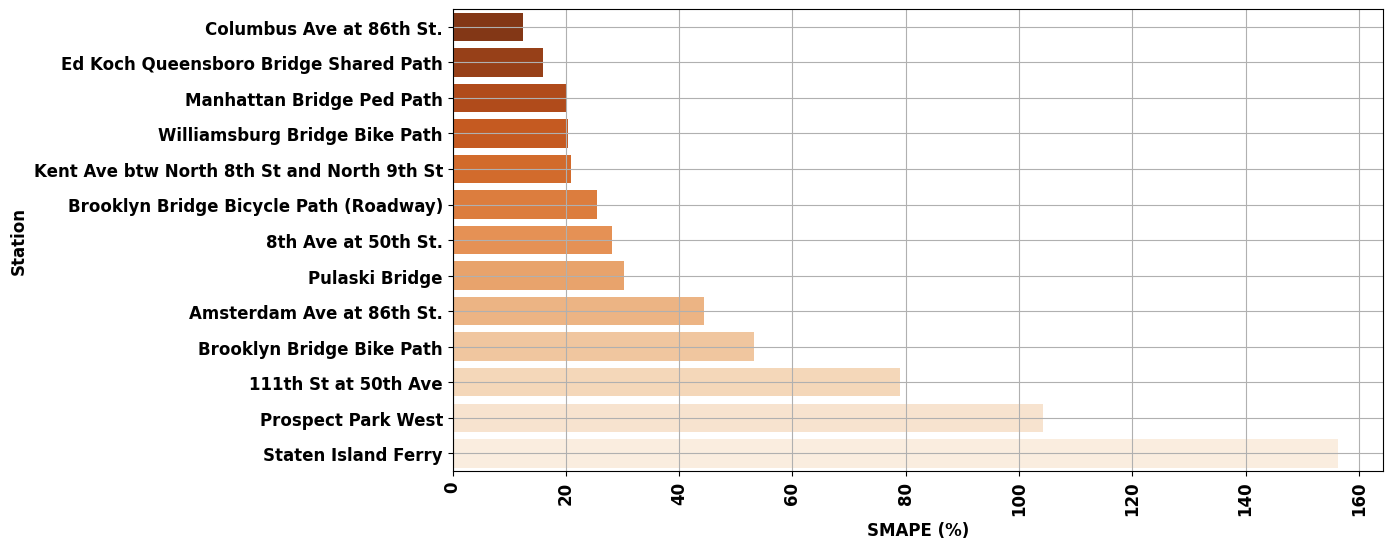

In [16]:
# Plot station-level SMAPE at daily level
plt.figure(figsize=(12, 6))
sns.barplot(
    data=station_error.sort_values('SMAPE'),
    y='name',
    x='SMAPE',
    palette='Oranges_r',
    hue='name',
    legend=False
)
plt.xticks(rotation=90)
plt.xlabel('SMAPE (%)')
plt.ylabel('Station')
plt.grid(True)
plt.show()

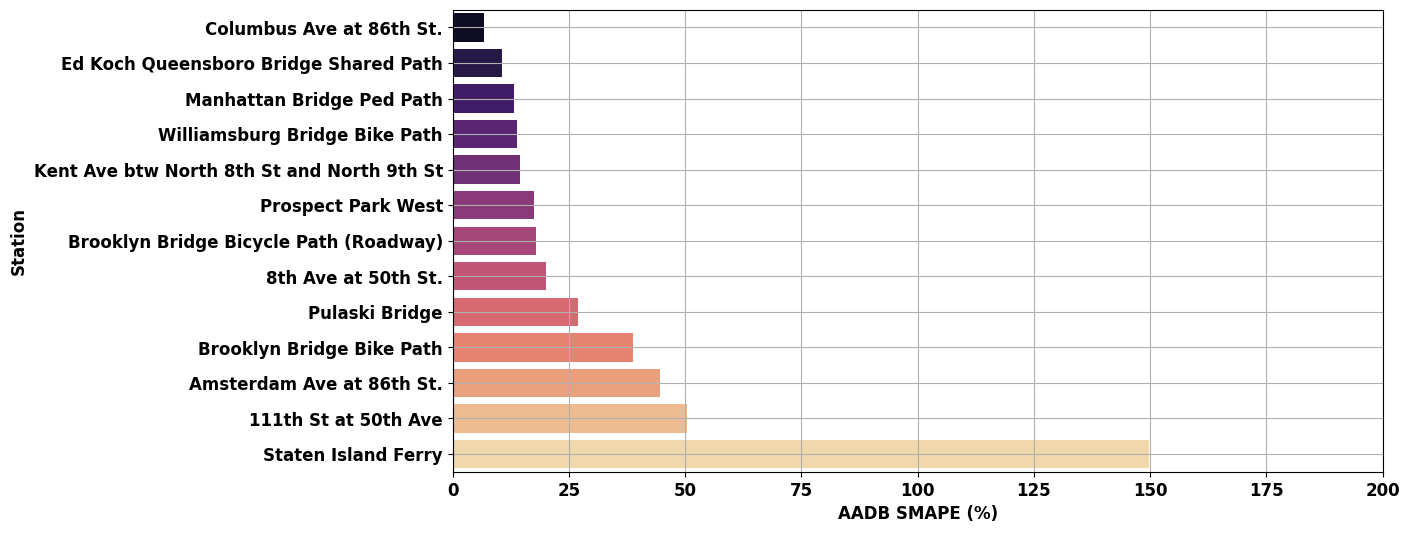

In [17]:
# Calculate errors at AADB level
aadb_eval_reset['absolute_error'] = np.abs(aadb_eval_reset['actual'] - aadb_eval_reset['predicted'])
aadb_eval_reset['squared_error'] = (aadb_eval_reset['actual'] - aadb_eval_reset['predicted']) ** 2
aadb_eval_reset['smape'] = 100 * 2 * np.abs(aadb_eval_reset['actual'] - aadb_eval_reset['predicted']) / (np.abs(aadb_eval_reset['actual']) + np.abs(aadb_eval_reset['predicted']))

# AADB SMAPE per station
plt.figure(figsize=(12, 6))
sns.barplot(y='name', 
            x='smape', 
            data=aadb_eval_reset.sort_values('smape'), 
            palette='magma',
            hue='name',
            legend=False
           )
plt.xlim(0, 200)
plt.ylabel('Station')
plt.xlabel('AADB SMAPE (%)')
plt.grid(True)
plt.show()

## Feature Importance Analysis

In [18]:
# Extract feature importances from the final trained Decision Tree
importances = final_tree.feature_importances_

# Create a dataframe of feature names and their corresponding importances
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


<ipython-input-19-354193891b23>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


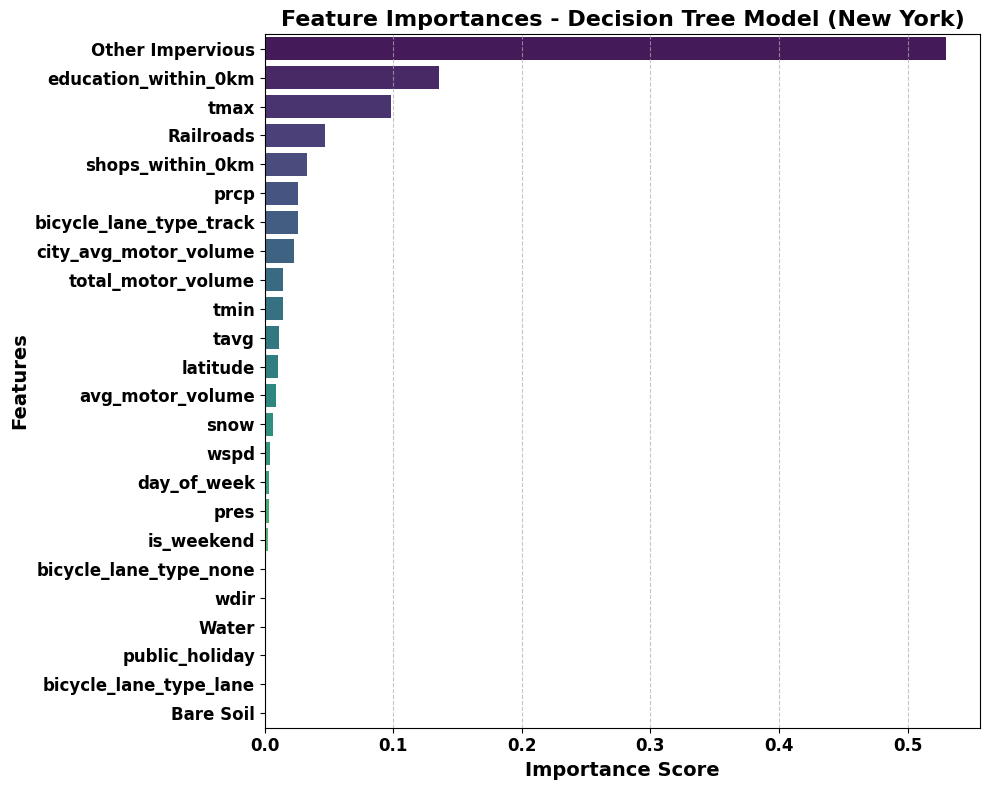

In [19]:
# Plotting all selected features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances - Decision Tree Model (New York)', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Grouped Feature Importance

In [20]:
# Define feature groups
feature_groups = {
    'Weather': ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'wdir'],
    'Temporal': ['day_of_week', 'is_weekend', 'public_holiday'],
    'Infrastructure': [
        'shops_within_0km', 'education_within_0km',
        'bicycle_lane_type_lane', 'bicycle_lane_type_none', 'bicycle_lane_type_track'
    ],
    'Land Cover': ['Other Impervious', 'Railroads', 'Bare Soil', 'Water'],
    'Traffic Volume': ['avg_motor_volume', 'total_motor_volume', 'city_avg_motor_volume'],
    'Geography': ['latitude']
}

In [21]:
# Prepare data
X = X_train[selected_features]
y = y_train

# Initialize
kf = KFold(n_splits=5, shuffle=True, random_state=42)
group_importance_scores = {group: [] for group in feature_groups.keys()}

# Loop over folds
for train_idx, val_idx in kf.split(X):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train model
    model = DecisionTreeRegressor(**grid_search.best_params_, random_state=42)
    model.fit(X_tr, y_tr)

    # Base prediction
    y_pred_base = model.predict(X_val)
    base_smape = smape(np.expm1(y_val), np.expm1(y_pred_base))  # back-transform log

    # For each feature group
    for group_name, features in feature_groups.items():
        X_val_permuted = X_val.copy()

        # Permute all features in the group
        for feat in features:
            if feat in X_val.columns:
                X_val_permuted[feat] = np.random.permutation(X_val_permuted[feat].values)

        # Predict with permuted features
        y_pred_permuted = model.predict(X_val_permuted)
        permuted_smape = smape(np.expm1(y_val), np.expm1(y_pred_permuted))

        # Importance = increase in SMAPE
        importance = permuted_smape - base_smape
        group_importance_scores[group_name].append(importance)

<ipython-input-22-ad0ea0d6d486>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df['Importance'], y=importance_df.index, palette='viridis')


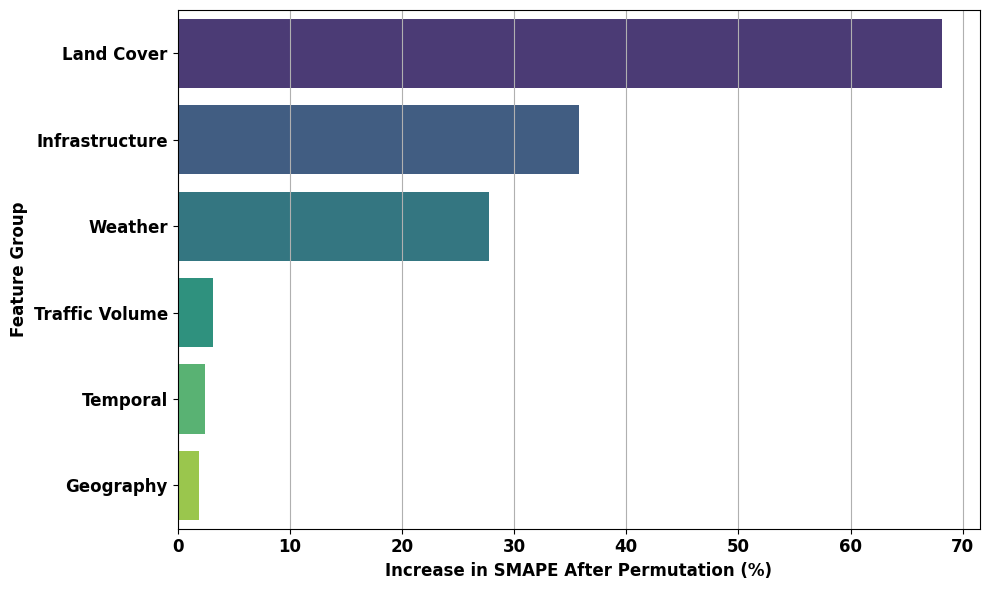

In [22]:
# Average across folds
group_importance_means = {group: np.mean(scores) for group, scores in group_importance_scores.items()}

# Sort and visualize
importance_df = pd.DataFrame.from_dict(group_importance_means, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=importance_df['Importance'], y=importance_df.index, palette='viridis')
plt.xlabel('Increase in SMAPE After Permutation (%)', fontweight='bold')
plt.ylabel('Feature Group', fontweight='bold')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()